In [1]:
from cpclasses import *

In [2]:
class PhysicsInformed(torch.nn.Module):

    def __init__(self, N_hidden_depth=2, N_hidden_width=16):
        super().__init__()
        assert N_hidden_depth > 0, 'Must have at least one hidden layer'

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, N_hidden_width),
            torch.nn.SiLU(),
            
                *[torch.nn.Linear(N_hidden_width, N_hidden_width), torch.nn.SiLU()] * (N_hidden_depth-1),
            torch.nn.Linear(N_hidden_width, 1)
         )

    def forward(self, x):
        return self.layers(x)

    def prediction_and_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]

        return prediction, derivative



In [3]:
PI = PhysicsInformed()

print(PI.layers)

print(PI.parameters())


Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): SiLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): SiLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)
<generator object Module.parameters at 0x00000125E3510660>


In [4]:
def target_fn(t, y_0 = 1, t_0 = 0):
    return 10 * y_0 / (10 - 9*y_0*(np.sin(t) - np.sin(t_0)))
def loss_fn(xs, ys):
    deriv = 0.9 * ys**2 * torch.cos(xs)
    return deriv


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(PI.parameters(), lr=0.001)
def train(x0, y0_target, epochs =2500, xmin=0, xmax = 5):
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        y0_predicted, _ = PI.prediction_and_derivative(x0)
        loss = criterion(y0_predicted, y0_target)

        xs = torch.rand((32,1), requires_grad=True) * (xmax - xmin) + xmin
        ys, dy_dxs = PI.prediction_and_derivative(xs)
        loss += 1/len(ys) * criterion(dy_dxs, loss_fn(xs, ys))
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    

Epoch 0, Loss: 0.6314635872840881
Epoch 0, Loss: 0.00575860682874918
Epoch 100, Loss: 0.007214128505438566
Epoch 200, Loss: 0.00371561455540359
Epoch 300, Loss: 0.007101329509168863
Epoch 400, Loss: 0.0035613628569990396
Epoch 500, Loss: 0.006138374097645283
Epoch 600, Loss: 0.005803913343697786
Epoch 700, Loss: 0.00473056873306632
Epoch 800, Loss: 0.005022779572755098
Epoch 0, Loss: 0.0035659915301948786
Epoch 100, Loss: 0.0037368517369031906
Epoch 200, Loss: 0.002984776394441724
Epoch 300, Loss: 0.0030060315039008856
Epoch 400, Loss: 0.0037569296546280384
Epoch 500, Loss: 0.0037753828801214695
Epoch 600, Loss: 0.0039832028560340405
Epoch 700, Loss: 0.004799533635377884
Epoch 800, Loss: 0.004644563887268305
Epoch 900, Loss: 0.004890006966888905
Epoch 1000, Loss: 0.005507925059646368
Epoch 1100, Loss: 0.004825509153306484
Epoch 1200, Loss: 0.0041228667832911015
Epoch 1300, Loss: 0.005270245019346476
Epoch 1400, Loss: 0.004972467664629221
Epoch 1500, Loss: 0.004590156488120556
Epoch 160

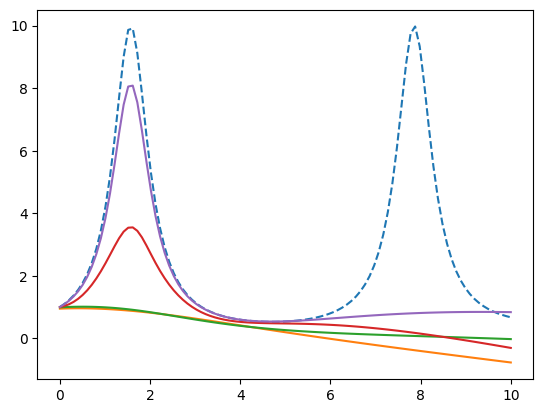

In [5]:
fig, ax = plt.subplots()


x_range = [0, 10]
xs_plot = torch.linspace(*x_range, 100, requires_grad=True).reshape(-1, 1)

xsnp = xs_plot.detach().numpy()
x0 = torch.zeros((1,1), requires_grad=True)
y0_target = torch.ones((1,1))
ax.plot(xsnp, target_fn(xsnp), '--', label='True solution')


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(PI.parameters(), lr=0.001)

            
for epoch in [100, 900, 9000, 90000]:
    train(x0, y0_target, epochs=epoch)
    ys, _ = PI.prediction_and_derivative(xs_plot)

    ax.plot(xsnp, ys.detach().numpy(), label=f'Epochs: {epoch}')


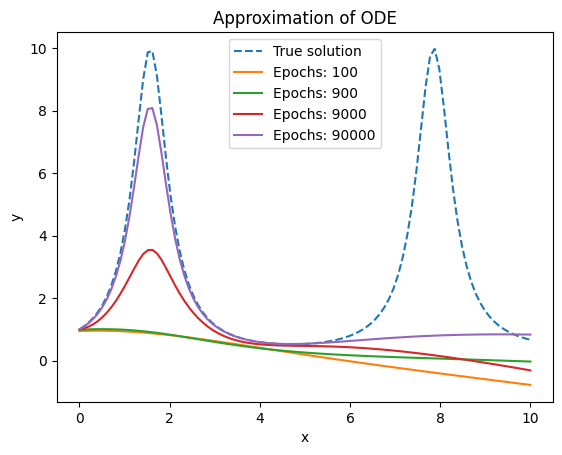

In [6]:
ax.set(xlabel='x', ylabel='y', title='Approximation of ODE')
ax.legend()

fig

save_plot(fig, 'ode_approximation, Adam.png')
fig

Epoch 0, Loss: 6.819340229034424
Epoch 0, Loss: 1.9560686349868774
Epoch 100, Loss: 1.7439526319503784
Epoch 200, Loss: 1.5404536724090576
Epoch 300, Loss: 1.018559217453003
Epoch 400, Loss: 0.8538714647293091
Epoch 500, Loss: 0.739089846611023
Epoch 600, Loss: 0.594978392124176
Epoch 700, Loss: 0.38557708263397217
Epoch 800, Loss: 0.4316256642341614
Epoch 0, Loss: 0.42727574706077576
Epoch 100, Loss: 0.3048691749572754
Epoch 200, Loss: 0.3377848267555237
Epoch 300, Loss: 0.2631416320800781
Epoch 400, Loss: 0.2444916069507599
Epoch 500, Loss: 0.25339335203170776
Epoch 600, Loss: 0.2312309592962265
Epoch 700, Loss: 0.2081936001777649
Epoch 800, Loss: 0.20497867465019226
Epoch 900, Loss: 0.13977909088134766
Epoch 1000, Loss: 0.1803833544254303
Epoch 1100, Loss: 0.12418552488088608
Epoch 1200, Loss: 0.10778620839118958
Epoch 1300, Loss: 0.14846165478229523
Epoch 1400, Loss: 0.0971173420548439
Epoch 1500, Loss: 0.10430844128131866
Epoch 1600, Loss: 0.08934152126312256
Epoch 1700, Loss: 0.1

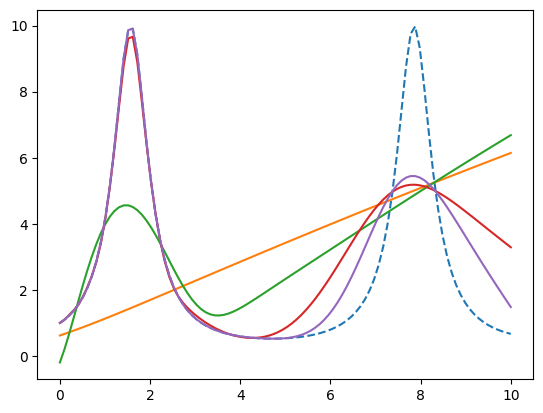

In [7]:
PI = PhysicsInformed()

optimizer = torch.optim.Adam(PI.parameters(), lr=0.001)


fig, ax = plt.subplots()


x_range = [0, 10]
xs_plot = torch.linspace(*x_range, 100, requires_grad=True).reshape(-1, 1)

xsnp = xs_plot.detach().numpy()
x0 = torch.tensor([1.09491408, 2.04667858, 7.37809938, 8.32986388], requires_grad=True).reshape(-1,1)
y0_target = torch.ones((4,1)) * 5

def train(x0, y0_target, epochs =2500, xmin=0, xmax = 5):
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        y0_predicted, _ = PI.prediction_and_derivative(x0)
        loss = 1/4 * criterion(y0_predicted, y0_target)

        xs = torch.rand((32,1), requires_grad=True) * (xmax - xmin) + xmin
        ys, dy_dxs = PI.prediction_and_derivative(xs)
        loss += 1/len(ys)*criterion(dy_dxs, loss_fn(xs, ys))
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

ax.plot(xsnp, target_fn(xsnp), '--', label='True solution')
epoch_count =0
for epoch in [100, 900, 9000, 90000]:
    epoch_count += epoch
    train(x0, y0_target, epochs=epoch)
    ys, _ = PI.prediction_and_derivative(xs_plot)

    ax.plot(xsnp, ys.detach().numpy(), label=f'Epochs: {epoch_count}')


In [8]:
print(x0.shape)
print(y0_target.shape)

torch.Size([4, 1])
torch.Size([4, 1])


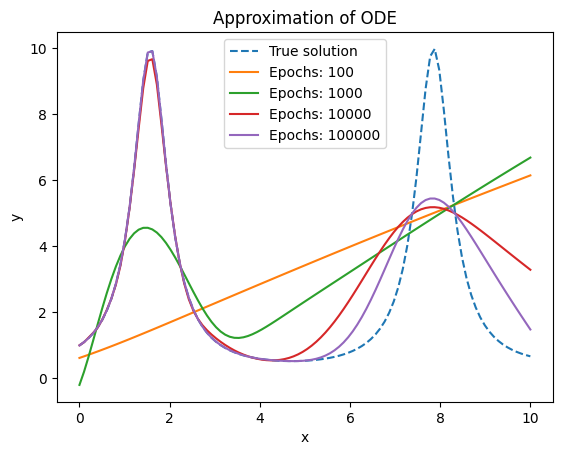

In [9]:
ax.set(xlabel='x', ylabel='y', title='Approximation of ODE')
ax.legend()

save_plot(fig, 'ode_approximation, better, Adam.png')
fig

In [10]:
if hasattr([0], 'len'):
    print('yes')

if hasattr([0], '__len__'):
    print('yes')

yes
